In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import glob
import pmdarima as pm


In [2]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
crimes_path = ('Data/*.csv')
files = glob.glob(crimes_path)
files

['Data\\Chicago-Crime_2001.csv',
 'Data\\Chicago-Crime_2002.csv',
 'Data\\Chicago-Crime_2003.csv',
 'Data\\Chicago-Crime_2004.csv',
 'Data\\Chicago-Crime_2005.csv',
 'Data\\Chicago-Crime_2006.csv',
 'Data\\Chicago-Crime_2007.csv',
 'Data\\Chicago-Crime_2008.csv',
 'Data\\Chicago-Crime_2009.csv',
 'Data\\Chicago-Crime_2010.csv',
 'Data\\Chicago-Crime_2011.csv',
 'Data\\Chicago-Crime_2012.csv',
 'Data\\Chicago-Crime_2013.csv',
 'Data\\Chicago-Crime_2014.csv',
 'Data\\Chicago-Crime_2015.csv',
 'Data\\Chicago-Crime_2016.csv',
 'Data\\Chicago-Crime_2017.csv',
 'Data\\Chicago-Crime_2018.csv',
 'Data\\Chicago-Crime_2019.csv',
 'Data\\Chicago-Crime_2020.csv',
 'Data\\Chicago-Crime_2021.csv',
 'Data\\Chicago-Crime_2022.csv']

In [7]:
crimes = pd.concat(pd.read_csv(file) for file in files)
crimes.info()
crimes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


In [8]:
fmt = '%m/%d/%Y %H:%M:%S %p'
crimes['Date'] = pd.to_datetime(crimes['Date'], format=fmt)

# Assault Forecast

In [66]:
#assault = crimes['Primary Type'].str.contains('ASSAULT')
assault = crimes['Primary Type'] == 'ASSAULT'
assault = crimes.loc[assault]
assault

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
14,1410662,2001-01-01 01:00:00,ASSAULT,SIMPLE,RESIDENCE,False,True,223,2.0,NaN,41.803253,-87.608098
28,1314713,2001-01-01 01:00:00,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,1322,12.0,NaN,41.899521,-87.672220
47,1358218,2001-01-01 01:00:00,ASSAULT,SIMPLE,APARTMENT,False,False,312,3.0,NaN,41.778744,-87.612135
56,1322396,2001-01-01 01:02:29,ASSAULT,AGGRAVATED: HANDGUN,RESIDENCE,False,True,611,6.0,NaN,41.750045,-87.667221
62,1310096,2001-01-01 01:07:38,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,413,4.0,NaN,41.729965,-87.600874
...,...,...,...,...,...,...,...,...,...,...,...,...
238845,12937815,2022-12-31 12:38:00,ASSAULT,SIMPLE,APARTMENT,False,False,1021,10.0,24.0,41.860229,-87.714022
238847,12937465,2022-12-31 12:41:00,ASSAULT,AGGRAVATED - OTHER DANGEROUS WEAPON,APARTMENT,False,True,921,9.0,15.0,41.817040,-87.684665
238853,12938029,2022-12-31 12:50:00,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
238854,12937822,2022-12-31 12:50:00,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669


In [68]:
assault_ts = assault.set_index('Date')
assault_ts

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1410662,ASSAULT,SIMPLE,RESIDENCE,False,True,223,2.0,NaN,41.803253,-87.608098
2001-01-01 01:00:00,1314713,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,1322,12.0,NaN,41.899521,-87.672220
2001-01-01 01:00:00,1358218,ASSAULT,SIMPLE,APARTMENT,False,False,312,3.0,NaN,41.778744,-87.612135
2001-01-01 01:02:29,1322396,ASSAULT,AGGRAVATED: HANDGUN,RESIDENCE,False,True,611,6.0,NaN,41.750045,-87.667221
2001-01-01 01:07:38,1310096,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,413,4.0,NaN,41.729965,-87.600874
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:38:00,12937815,ASSAULT,SIMPLE,APARTMENT,False,False,1021,10.0,24.0,41.860229,-87.714022
2022-12-31 12:41:00,12937465,ASSAULT,AGGRAVATED - OTHER DANGEROUS WEAPON,APARTMENT,False,True,921,9.0,15.0,41.817040,-87.684665
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966


In [69]:
assault_ts.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:02:29',
               '2001-01-01 01:07:38', '2001-01-01 01:30:00',
               '2001-01-01 01:30:00', '2001-01-01 01:36:00',
               '2001-01-01 02:00:00', '2001-01-01 02:00:00',
               ...
               '2022-12-31 12:00:00', '2022-12-31 12:00:00',
               '2022-12-31 12:05:00', '2022-12-31 12:15:00',
               '2022-12-31 12:30:00', '2022-12-31 12:38:00',
               '2022-12-31 12:41:00', '2022-12-31 12:50:00',
               '2022-12-31 12:50:00', '2022-12-31 12:52:00'],
              dtype='datetime64[ns]', name='Date', length=501103, freq=None)

In [70]:
assault_ts = assault_ts.resample('M').size()

In [71]:
assault_ts.isna().sum()

0

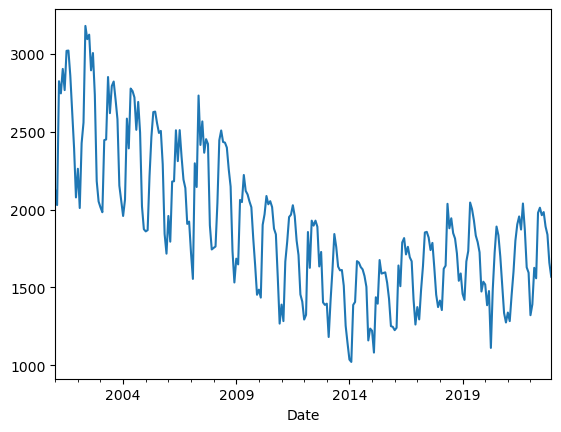

In [72]:
assault_ts.plot();

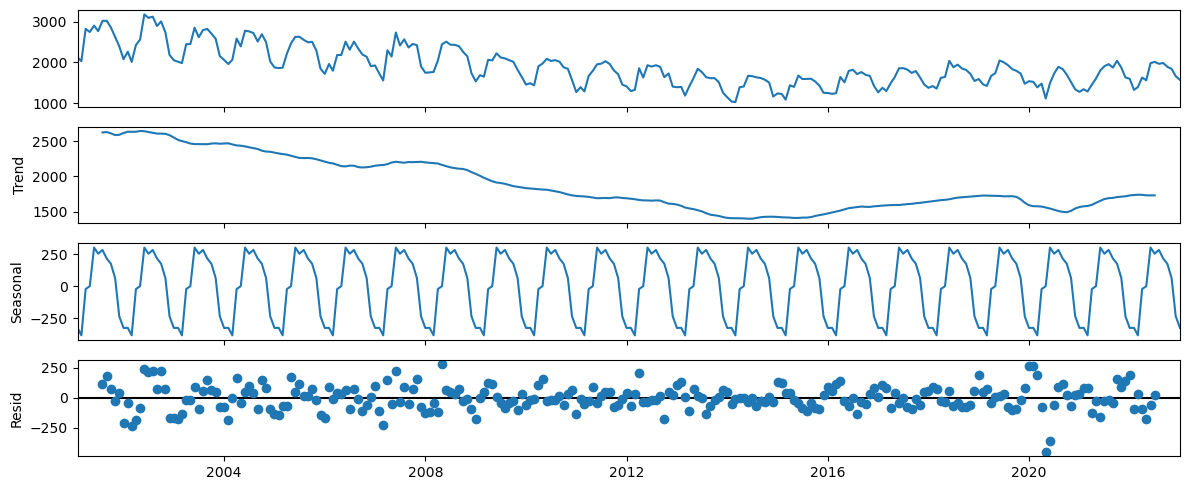

In [74]:
decomp = tsa.seasonal_decompose(assault_ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [76]:
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(assault_ts.max()-assault_ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 684.8888888888889 which is ~31.75% of the variation in time series.


In [77]:
ndiffs(assault_ts)

1

In [78]:
nsdiffs(assault_ts, m=12)

0

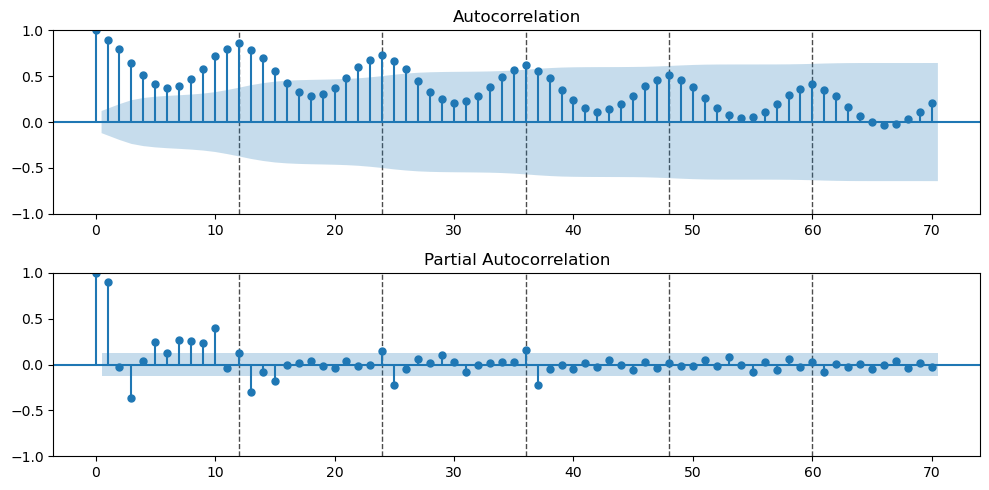

In [79]:
plot_acf_pacf(assault_ts, annotate_seas=True, m = 12, nlags = 70);

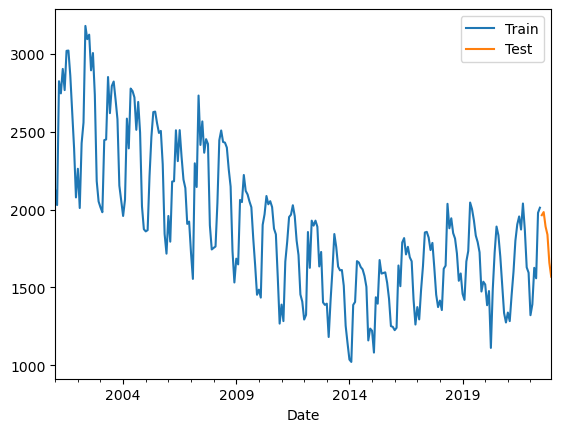

In [80]:
test_lags = 6
train, test = train_test_split(assault_ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [81]:
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

arima = tsa.ARIMA(train, order = (p,d,q)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1739.879
Date:                Wed, 14 Feb 2024   AIC                           3483.759
Time:                        21:37:33   BIC                           3490.857
Sample:                    01-31-2001   HQIC                          3486.613
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.073     -0.274      0.784      -0.163       0.123
sigma2      4.459e+04   3122.878     14.277      0.000    3.85e+04    5.07e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.08
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

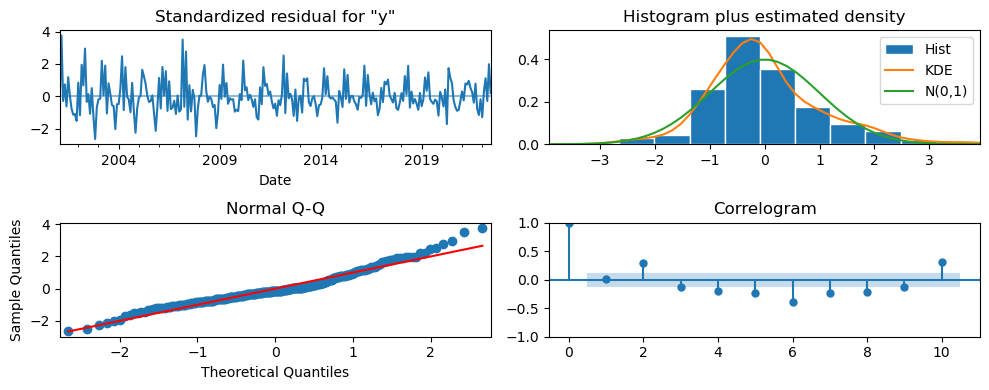

In [82]:
fig = arima.plot_diagnostics()
fig.set_size_inches(10,4)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 193.683
- MSE = 61,167.801
- RMSE = 247.321
- R^2 = -1.586
- MAPE = 11.49%


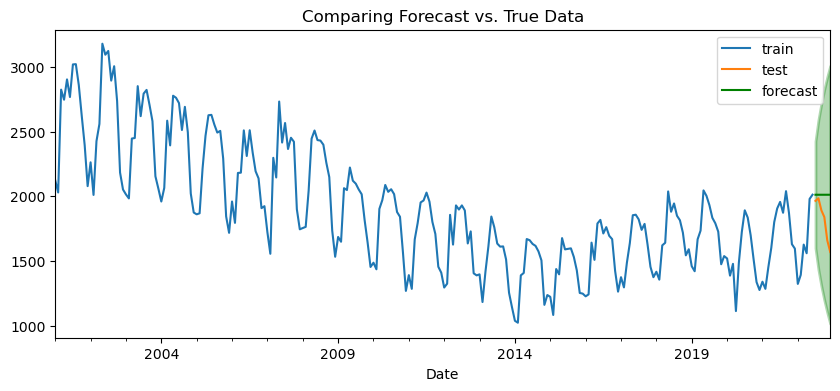

In [83]:
forecast_df = arima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

In [84]:
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -1655.010
Date:                          Wed, 14 Feb 2024   AIC                           3316.021
Time:                                  21:37:39   BIC                           3326.668
Sample:                              01-31-2001   HQIC                          3320.302
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2933      0.059     -4.951      0.000      -0.409      -0.177
ar.S.L12       0.7421      0.033     22.676      0.000       0.678       0.806
sigma2      2.213e+04   1545.509     14.320      0.000    1.91e+04    2.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                33.00
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

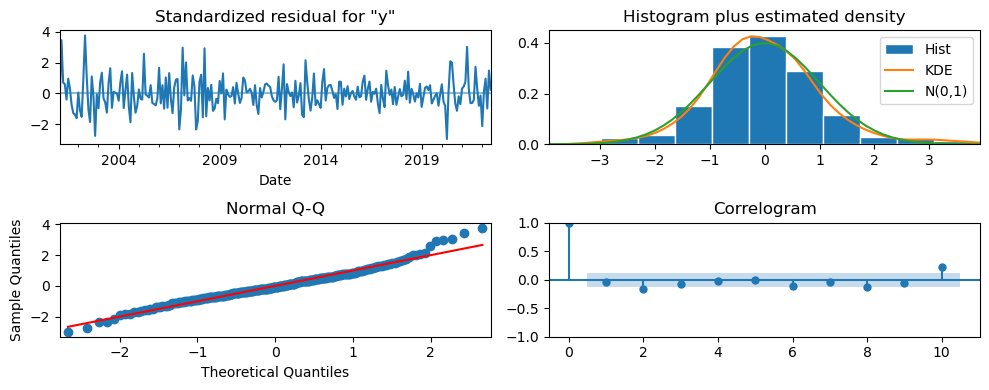

In [85]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,4)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 147.020
- MSE = 27,179.251
- RMSE = 164.861
- R^2 = -0.149
- MAPE = 8.38%


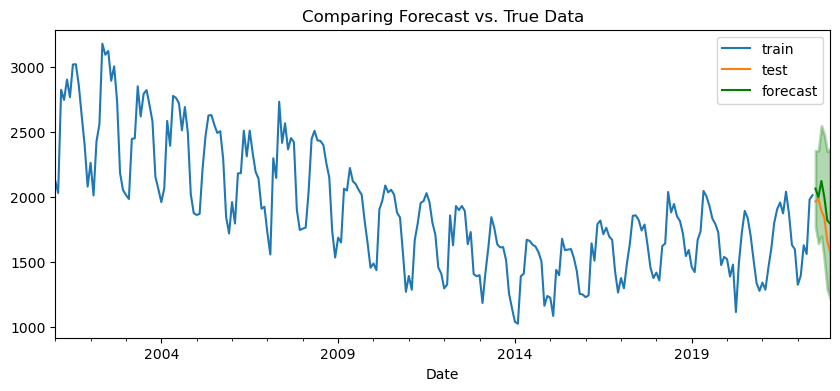

In [86]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

In [87]:
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3483.860, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3318.021, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3405.065, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3481.861, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3485.758, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3404.125, Time=0.13 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3337.645, Time=0.07 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3313.233, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3462.085, Time=0.09 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3

In [88]:
print(auto_model.order)
print(auto_model.seasonal_order)

(4, 1, 0)
(2, 0, 2, 12)


In [89]:
p = 4  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

P = 2  # Seasonal AR
D = 0  # Seasonal differencing
Q = 2  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()
sarima.summary()

C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  258
Model:             ARIMA(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1592.026
Date:                               Wed, 14 Feb 2024   AIC                           3202.051
Time:                                       21:38:42   BIC                           3233.993
Sample:                                   01-31-2001   HQIC                          3214.897
                                        - 06-30-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4332      0.059     -7.380      0.000      -0.548      -0.318
ar.L2         -0.2660      0.066     -4.056      0.000      -0.395      -0.137
ar.L3         -0.2502      0.061     -4.091      0.000      -0.370      -0.130
ar.L4         -0.1574      0.065     -2.419      0.016      -0.285      -0.030
ar.S.L12       1.9968      0.011    184.838      0.000       1.976       2.018
ar.S.L24      -0.9978      0.011    -94.997      0.000      -1.018      -0.977
ma.S.L12      -1.8805      0.087    -21.579      0.000      -2.051      -1.710
ma.S.L24       0.8849      0.083     10.654      0.000       0.722       1.048
sigma2      1.131e+04   1.55e-05   7.29e+08      0.000    1.13e+04    1.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                29.50
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.13
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.05e+24. Standard errors may be unstable.
"""

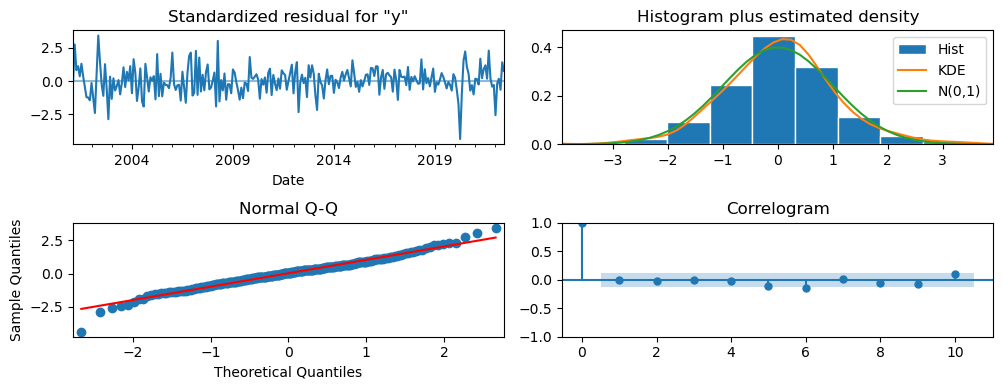

In [90]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,4)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 37.752
- MSE = 2,040.527
- RMSE = 45.172
- R^2 = 0.914
- MAPE = 2.12%


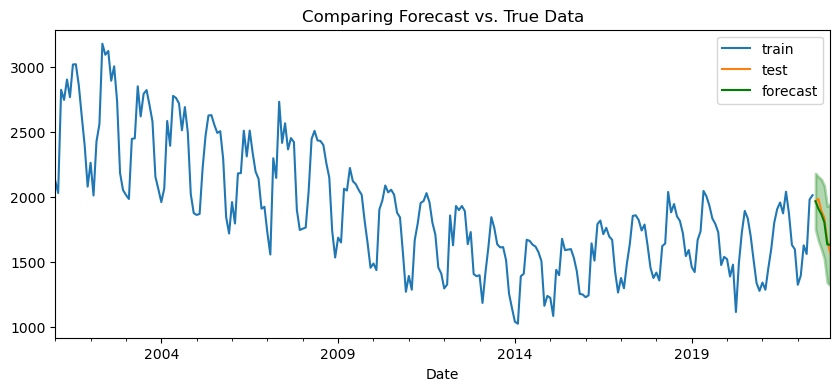

In [91]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

I will go with the (4,1,0)(2,0,2,12) model that was recommended by the auto arima, because the regression metrics performed better. 

In [92]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2022-07-31 00:00:00', freq='M'),
 Timestamp('2022-12-31 00:00:00', freq='M'))

In [93]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

1965.53164798858

In [94]:
final_value = forecast_df['mean'].iloc[-1]
final_value

1630.4281867505595

In [95]:
change = final_value - starting_value
change

-335.1034612380206

In [96]:
perc_change = (change / starting_value) * 100
perc_change

-17.04899850281971

# Narcotics Forecast

In [36]:
narcotics = crimes['Primary Type'].str.contains('NARCOTICS')
narcotics = crimes.loc[narcotics]
narcotics

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
15,1325760,2001-01-01 01:00:00,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN
65,1327471,2001-01-01 01:10:00,NARCOTICS,POSS: CRACK,PARKING LOT/GARAGE(NON.RESID.),True,False,2424,24.0,NaN,42.019331,-87.679878
67,1325495,2001-01-01 01:10:00,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,SIDEWALK,True,False,424,4.0,NaN,41.736585,-87.544309
70,1325471,2001-01-01 01:12:00,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,RESIDENCE,True,False,2411,24.0,NaN,42.012293,-87.694610
81,1327596,2001-01-01 01:20:00,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,1414,14.0,NaN,41.921770,-87.700210
...,...,...,...,...,...,...,...,...,...,...,...,...
238296,12937989,2022-12-31 03:37:00,NARCOTICS,SOLICIT NARCOTICS ON PUBLIC WAY,SIDEWALK,True,False,1122,11.0,28.0,41.880749,-87.723929
238334,12938016,2022-12-31 04:20:00,NARCOTICS,POSSESS - HEROIN (WHITE),SIDEWALK,True,False,1112,11.0,27.0,41.901522,-87.720176
238381,12938026,2022-12-31 05:03:00,NARCOTICS,POSSESS - CANNABIS MORE THAN 30 GRAMS,STREET,True,False,1522,15.0,29.0,41.880951,-87.764879
238485,12938151,2022-12-31 07:25:00,NARCOTICS,POSSESS - AMPHETAMINES,STREET,False,False,533,5.0,9.0,41.659281,-87.597701


In [37]:
narcotics_ts = narcotics.set_index('Date')
narcotics_ts

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1325760,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN
2001-01-01 01:10:00,1327471,NARCOTICS,POSS: CRACK,PARKING LOT/GARAGE(NON.RESID.),True,False,2424,24.0,NaN,42.019331,-87.679878
2001-01-01 01:10:00,1325495,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,SIDEWALK,True,False,424,4.0,NaN,41.736585,-87.544309
2001-01-01 01:12:00,1325471,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,RESIDENCE,True,False,2411,24.0,NaN,42.012293,-87.694610
2001-01-01 01:20:00,1327596,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,1414,14.0,NaN,41.921770,-87.700210
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 03:37:00,12937989,NARCOTICS,SOLICIT NARCOTICS ON PUBLIC WAY,SIDEWALK,True,False,1122,11.0,28.0,41.880749,-87.723929
2022-12-31 04:20:00,12938016,NARCOTICS,POSSESS - HEROIN (WHITE),SIDEWALK,True,False,1112,11.0,27.0,41.901522,-87.720176
2022-12-31 05:03:00,12938026,NARCOTICS,POSSESS - CANNABIS MORE THAN 30 GRAMS,STREET,True,False,1522,15.0,29.0,41.880951,-87.764879


In [38]:
narcotics_ts.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 01:10:00',
               '2001-01-01 01:10:00', '2001-01-01 01:12:00',
               '2001-01-01 01:20:00', '2001-01-01 01:30:00',
               '2001-01-01 01:35:00', '2001-01-01 01:45:00',
               '2001-01-01 01:45:00', '2001-01-01 01:55:00',
               ...
               '2022-12-30 10:30:00', '2022-12-30 11:05:00',
               '2022-12-30 11:54:00', '2022-12-30 12:11:00',
               '2022-12-31 01:43:00', '2022-12-31 03:37:00',
               '2022-12-31 04:20:00', '2022-12-31 05:03:00',
               '2022-12-31 07:25:00', '2022-12-31 09:45:00'],
              dtype='datetime64[ns]', name='Date', length=746155, freq=None)

In [39]:
narcotics_ts = narcotics_ts.resample('M').size()

In [40]:
narcotics_ts.isna().sum()

0

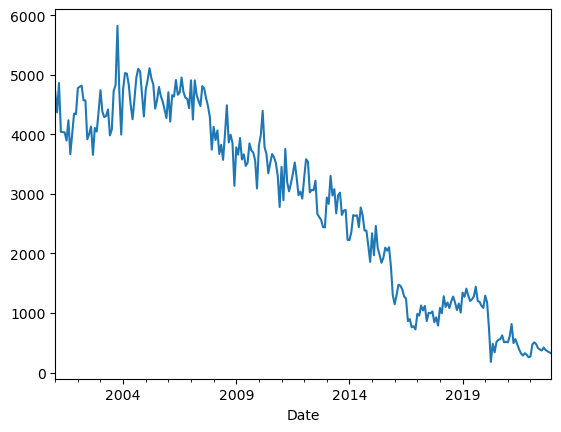

In [41]:
narcotics_ts.plot();

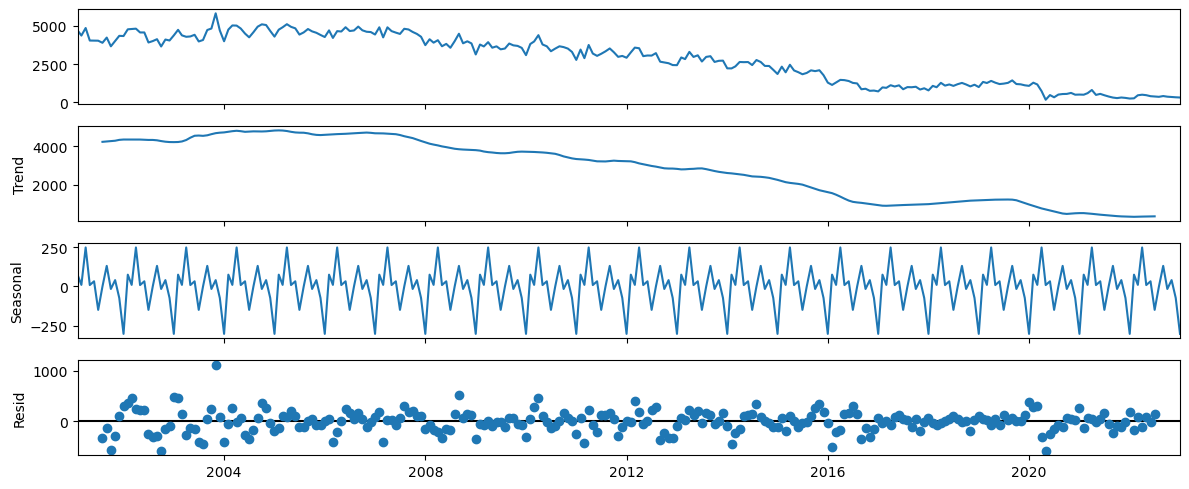

In [42]:
decomp = tsa.seasonal_decompose(narcotics_ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [43]:
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(narcotics_ts.max()-narcotics_ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 550.6626984126984 which is ~9.76% of the variation in time series.


In [44]:
ndiffs(narcotics_ts)

1

In [45]:
nsdiffs(narcotics_ts, m=12)

0

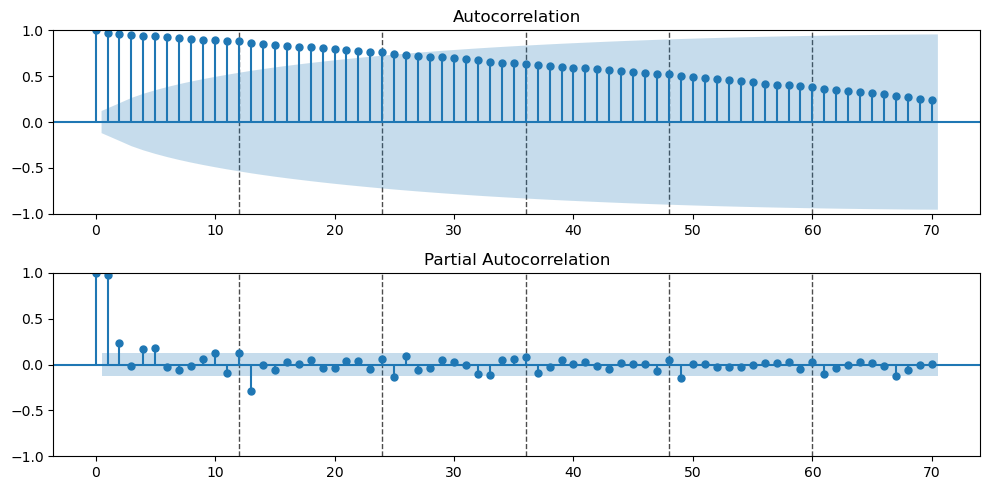

In [46]:
plot_acf_pacf(narcotics_ts, annotate_seas=True, m = 12, nlags = 70);

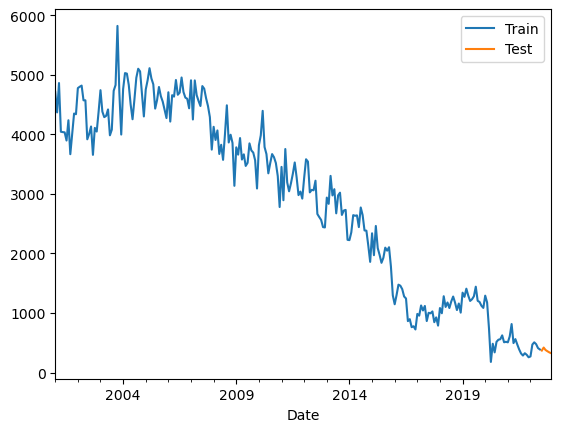

In [47]:
test_lags = 6
train, test = train_test_split(narcotics_ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [48]:
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

arima = tsa.ARIMA(train, order = (p,d,q)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1819.310
Date:                Wed, 14 Feb 2024   AIC                           3642.621
Time:                        18:36:39   BIC                           3649.719
Sample:                    01-31-2001   HQIC                          3645.475
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3159      0.040     -7.817      0.000      -0.395      -0.237
sigma2      8.259e+04   6136.977     13.457      0.000    7.06e+04    9.46e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.87
Prob(Q):                              0.83   Prob(JB):                         0.01
Heteroskedasticity (H):               0.25   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

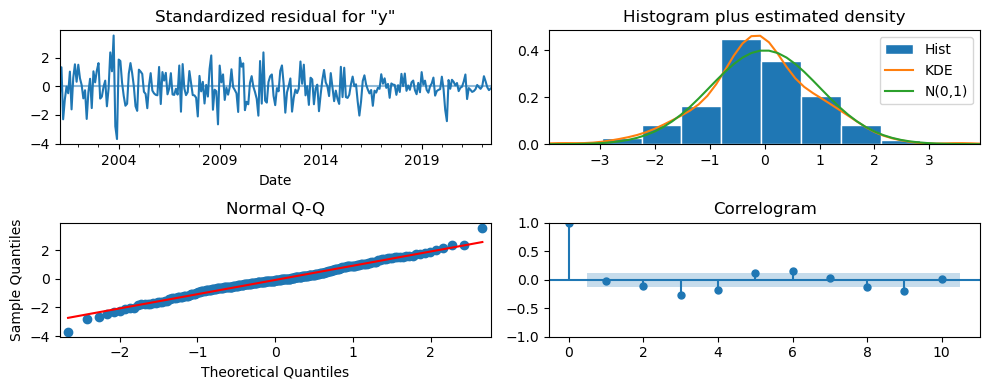

In [49]:
fig = arima.plot_diagnostics()
fig.set_size_inches(10,4)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 37.585
- MSE = 1,751.920
- RMSE = 41.856
- R^2 = -0.887
- MAPE = 10.70%


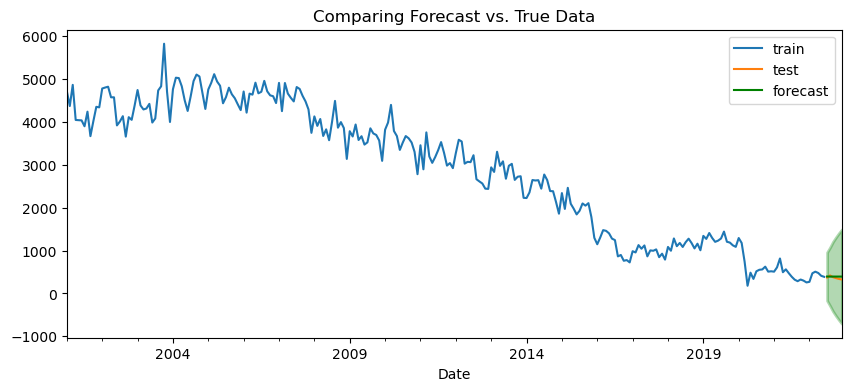

In [50]:
forecast_df = arima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

In [51]:
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  258
Model:             ARIMA(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1774.937
Date:                            Wed, 14 Feb 2024   AIC                           3557.873
Time:                                    18:36:40   BIC                           3572.069
Sample:                                01-31-2001   HQIC                          3563.582
                                     - 06-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1779      0.036     -4.901      0.000      -0.249      -0.107
ar.S.L12       0.9539      0.025     37.810      0.000       0.904       1.003
ma.S.L12      -0.7575      0.073    -10.416      0.000      -0.900      -0.615
sigma2      5.708e+04   3485.095     16.378      0.000    5.02e+04    6.39e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                81.90
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

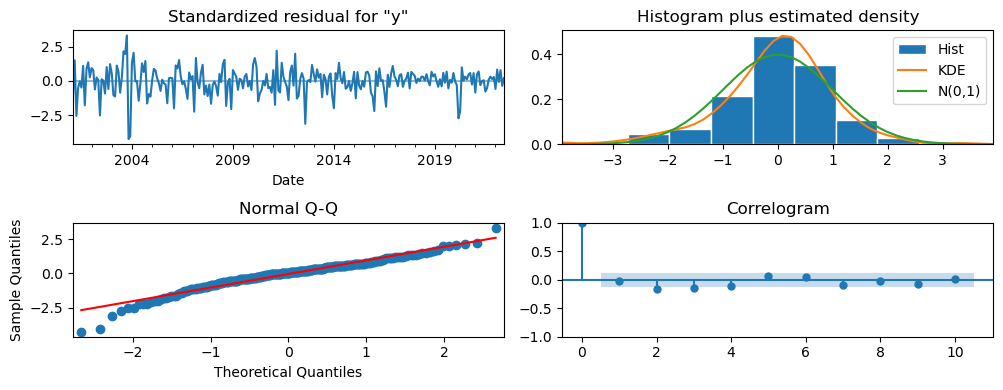

In [52]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,4)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 34.444
- MSE = 2,312.194
- RMSE = 48.085
- R^2 = -1.490
- MAPE = 9.82%


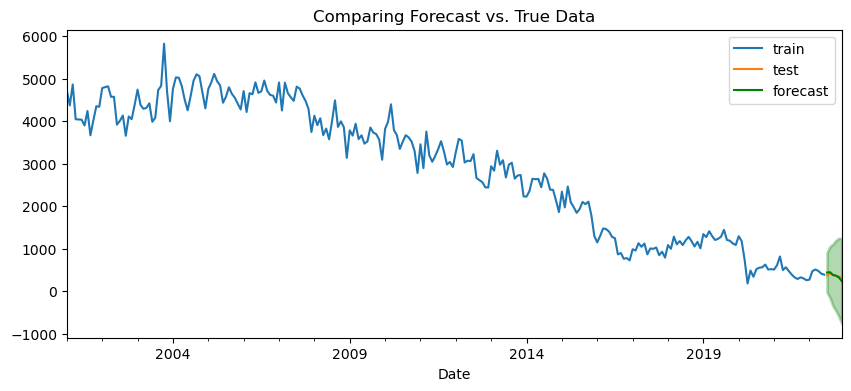

In [53]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

In [54]:
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3669.016, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3583.957, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3595.909, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3667.813, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3643.189, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3577.354, Time=0.53 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3559.635, Time=0.84 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3559.679, Time=0.36 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3559.353, Time=0.87 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3589.825, Time=0.33 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3602.922, Time=0.12 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3566.717, Time=0.75 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [55]:
print(auto_model.order)
print(auto_model.seasonal_order)

(4, 1, 0)
(1, 0, 1, 12)


In [56]:
p = 2  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  258
Model:             ARIMA(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1773.003
Date:                            Wed, 14 Feb 2024   AIC                           3556.007
Time:                                    18:37:16   BIC                           3573.752
Sample:                                01-31-2001   HQIC                          3563.143
                                     - 06-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1962      0.038     -5.176      0.000      -0.270      -0.122
ar.L2         -0.1239      0.056     -2.214      0.027      -0.234      -0.014
ar.S.L12       0.9493      0.026     36.117      0.000       0.898       1.001
ma.S.L12      -0.7360      0.077     -9.554      0.000      -0.887      -0.585
sigma2      5.613e+04   3561.694     15.759      0.000    4.91e+04    6.31e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                66.79
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

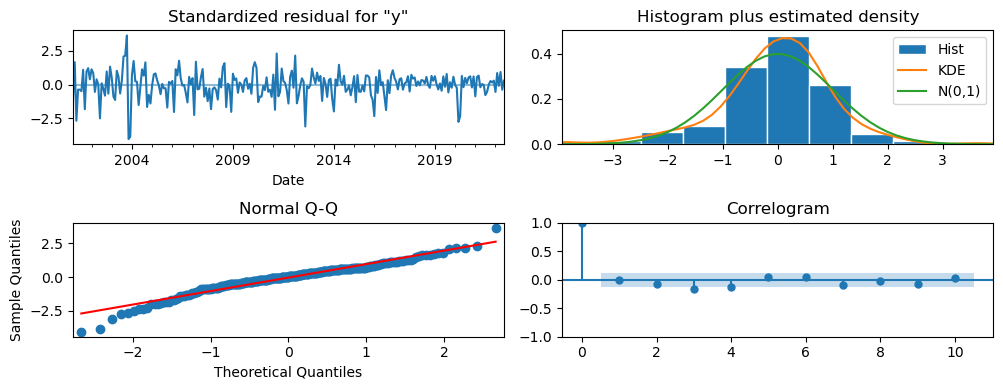

In [57]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,4)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 33.293
- MSE = 2,098.897
- RMSE = 45.814
- R^2 = -1.261
- MAPE = 9.40%


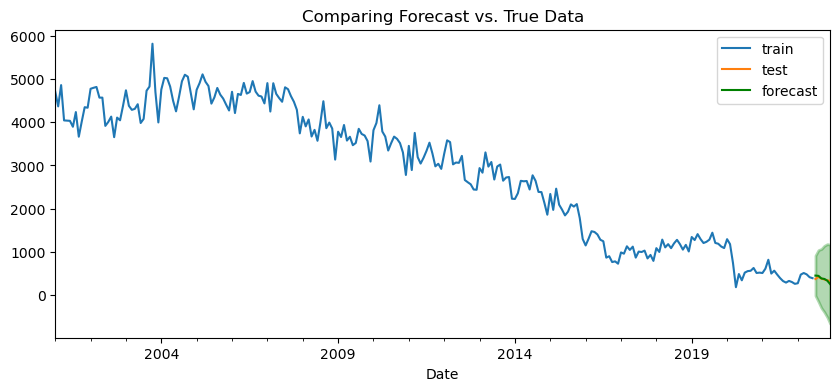

In [58]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

I chose the (2,1,0)(1,0,1,12) model because the regression metrics is better by .4%.

In [59]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2022-07-31 00:00:00', freq='M'),
 Timestamp('2022-12-31 00:00:00', freq='M'))

In [60]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

448.02669673635506

In [61]:
final_value = forecast_df['mean'].iloc[-1]
final_value

249.03962224554738

In [62]:
change = final_value - starting_value
change

-198.9870744908077

In [63]:
perc_change = (change / starting_value) * 100
perc_change

-44.4141110206884

Which is forecasted to have the highest monthly count of crimes at the end of the forecast?

-The assault crimes is forecasted to have a higher crime count than the narcotics forecast.

Which is forecasted to have the highest net change by the end of the forecast?

-The assault crimes is forecasted to have the highest net change by the end of the forecast.

Which is forecasted to have the highest percent change by the end of the forecast?

-Narcotics is forecasted to have the highest percent change by the end of the forecast.

Final recommendation: The assault crimes should be focused on more because they have a higher crime rate.